## Importing libraries

In [45]:
import requests
import pickle
import time
import networkx as nx
from time import sleep
from tqdm import tqdm
import matplotlib.pyplot as plt

api_key = "4cf138d1c7a61ceb0ca55c01b032a656"
base_url = "http://ws.audioscrobbler.com/2.0/"
max_depth = 2  # how many layers to crawl (e.g. 0 = just seed, 1 = seed + friends)

In [32]:
def get_friends(username):

    friends = []
    limit = 50
    page = 1
    
    while True:
        # call the API and return list of friends
        get_friends_params= {
            'method': 'user.getfriends',
            'user': username,
            'api_key': api_key,
            'format': 'json',
            'limit' : limit,
            'page' : page
        } # read last.fm's documentation about its API at https://www.last.fm/api !

        result=requests.get(base_url, get_friends_params)
        print("sending request to last.fm. page " + str(page))

        if result.status_code == 200: #successful request!
            data = result.json() #thanks to the .json() method of the request library
            page_friends = []
            if 'friends' in data and 'user' in data['friends']:
                page_friends = [curr_user['name'] for curr_user in data['friends']['user']]
            friends.extend(page_friends)
            if len(page_friends) < limit:
                break #no more pages!
            else:
                page += 1 #next page

        else:
            print("Error: code " + str(result.status_code))
            break
            
    return friends

In [76]:
def get_friends2(username):

    global count_400
    friends = []
    limit = 50
    page = 1
    retry_count = 0
    
    while True:
        # call the API and return list of friends
        get_friends_params= {
            'method': 'user.getfriends',
            'user': username,
            'api_key': api_key,
            'format': 'json',
            'limit' : limit,
            'page' : page
        } # read last.fm's documentation about its API at https://www.last.fm/api !

        try:
            response = requests.get(base_url, params=get_friends_params, timeout=10)  # 10 seconds timeout
            if response.status_code == 200: #successful request
                data = response.json()
                page_friends = []
                if 'friends' in data and 'user' in data['friends']:
                    page_friends = [u['name'] for u in data['friends']['user']]
                friends.extend(page_friends)
                if len(page_friends) < limit:
                    break
                else:
                    page += 1
                

            elif response.status_code == 400: #sometimes a bad request... just happens. wait 2 second and try again, if still nothing happens move on with your life
                if retry_count < 2:
                    retry_count += 1
                    print(f"Error: code {response.status_code}. Retrying...")
                    time.sleep(0.5)
                    continue
                else:
                    print(f"Got another error, code {response.status_code}. Moving on with our sad sad life.")
                    count_400 += 1
                    break
            else:
                print(f"Error: code {response.status_code}")
                break

        except requests.exceptions.Timeout:
            if retry_count < 2:
                retry_count += 1
                print("Timeout occurred. Retrying in 5 seconds...")
                time.sleep(5)  # wait before retrying
                continue
            else:
                print("Max retries reached for timeout, stopping.")
            break

        except requests.exceptions.RequestException as e:
            print(f"Request failed: {e}")
            break

    return friends

In [62]:
#does it work? these are my friends
len(get_friends('ko_tatsu'))

sending request to last.fm. page 1
sending request to last.fm. page 2
sending request to last.fm. page 3
sending request to last.fm. page 4
sending request to last.fm. page 5


206

Now we add the seed to the network and add its friends.

In [90]:
def add_node(graph,node):
    graph.add_node(node)
    friends_list = get_friends(node)
    for friend in friends_list:
        graph.add_edge(node, friend)
    return friends_list

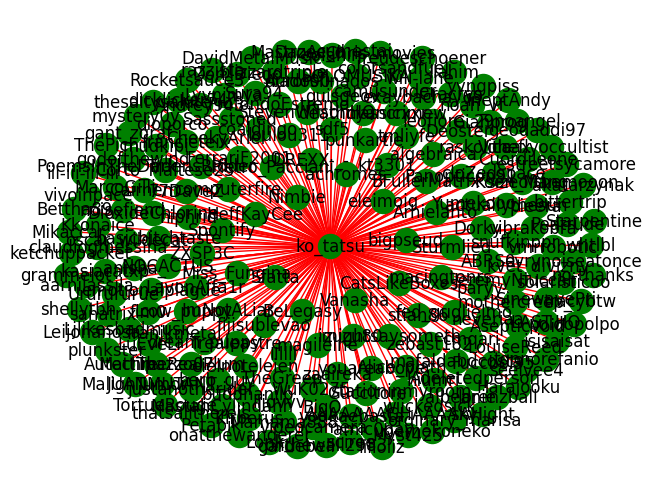

In [64]:
G = nx.Graph() #our network
add_node(G,'ko_tatsu')
nx.draw(G, with_labels=True, node_size=300, node_color="green", edge_color="red")
plt.show()

Now we need to populate the whole graph

In [75]:
count_400 = 0
count_cycles = 0
def explore_friends(graph, node, depth, max_depth):

    global count_cycles
    count_cycles +=1
    visited = set()
    if depth > max_depth:
        return
    if node in visited:
        print(f"{node} already visited!")
        return 
    
    visited.add(node)
    print(f"Exploring {node} at depth {depth}")
    friends_list = add_node(graph, node)

    for friend in friends_list: #recursion
        explore_friends(G, friend, depth+1, max_depth)

### FOLLIA TOTALE: DEPTH 2

In [ ]:
G = nx.Graph() #our network
depth = 0
seed = 'ko_tatsu'
explore_friends(G, seed, depth, 2)

ko_tatsu already visited!


In [51]:
G.number_of_edges()

0

In [52]:
nx.write_gpickle(G, "lastfm_721k.gpickle")

AttributeError: module 'networkx' has no attribute 'write_gpickle'

In [67]:
largest_cc = max(nx.connected_components(G), key=len)
G_sub = G.subgraph(largest_cc)
pos = nx.spring_layout(G_sub)  # or circular/shell for speed
nx.draw(G_sub, pos, with_labels=True, node_size=20)

Error in callback <function flush_figures at 0x0000027D804A3B00> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [ ]:
with open('my_graph.pkl', 'wb') as f:
    pickle.dump(G, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('my_graph.pkl', 'rb') as f:
    Glarge = pickle.load(f)

#### Be quiet for several days : depth one

In [97]:
E = nx.Graph()
seed = 'ko_tatsu'
explore_friends(E, seed, 0, 1)

Exploring ko_tatsu at depth 0
sending request to last.fm. page 1
sending request to last.fm. page 2
sending request to last.fm. page 3
sending request to last.fm. page 4
sending request to last.fm. page 5
Exploring amic0gay at depth 1
sending request to last.fm. page 1
Exploring cow_puppy at depth 1
sending request to last.fm. page 1
sending request to last.fm. page 2
Exploring Panopticon91 at depth 1
sending request to last.fm. page 1
sending request to last.fm. page 2
sending request to last.fm. page 3
sending request to last.fm. page 4
sending request to last.fm. page 5
sending request to last.fm. page 6
sending request to last.fm. page 7
Exploring LuEveLi at depth 1
sending request to last.fm. page 1
Exploring FerrariF2001 at depth 1
sending request to last.fm. page 1
sending request to last.fm. page 2
Exploring Deoster at depth 1
sending request to last.fm. page 1
Exploring AAAAAAAGHAAAAAH at depth 1
sending request to last.fm. page 1
sending request to last.fm. page 2
sending req

In [98]:
E.number_of_nodes()

207